In [2]:
# =============================================================================
# load cleaned 1-minute bch data from sqlite table
# =============================================================================
import pandas as pd
import sqlite3

# =============================================================================
# define path to sqlite database and table name
# =============================================================================
db_path   = "data/bchusdt_data.db"
table     = "bchusdt_1m"

# =============================================================================
# load dataframe from sqlite database
# =============================================================================
conn      = sqlite3.connect(db_path)
query     = f"""select * from bchusdt_1m {table}"""
df        = pd.read_sql(query, conn)
conn.close()


# =============================================================================
# display basic info
# =============================================================================
print("number of rows:       ", len(df))
print("date range:           ", df['open_time'].min(), "to", df['open_time'].max())

display(df.tail())

number of rows:        3100254
date range:            2019-11-28 10:00:00 to 2025-10-22 00:00:00


,open_time,open,high,low,close,volume
3100249,2025-10-21 23:56:00,481.7,482.1,481.3,481.3,40.247
3100250,2025-10-21 23:57:00,481.3,481.6,480.8,481.6,24.688
3100251,2025-10-21 23:58:00,481.5,481.8,481.2,481.3,19.189
3100252,2025-10-21 23:59:00,481.3,481.3,480.7,480.8,10.773
3100253,2025-10-22 00:00:00,480.8,480.8,480.4,480.8,14.296


# target variable

In [3]:
# =============================================================================
# CALCULATE 4-HOUR FUTURE MAXIMUM CLOSE AND RATIO
# =============================================================================
import numpy as np

# Biztonsági másolat a DataFrame-ről
df = df.copy()

# 4 óra = 240 perc
window_size  = 240
close_values = df['close'].values

# Inicializáljuk a max értéktömböt
future_max_close = np.full(len(df), np.nan)

# Iterálunk minden soron
for i in range(len(df) - window_size):
    future_window       = close_values[i+1 : i+1+window_size]
    future_max_close[i] = np.max(future_window)

# Új oszlop a jövőbeli max záráshoz
df['future_4h_max_close'] = future_max_close

# Arány számítása
df['future_4h_max_ratio'] = df['future_4h_max_close'] / df['close']
df.head()

,open_time,open,high,low,close,volume,future_4h_max_close,future_4h_max_ratio
0,2019-11-28 10:00:00,220.08,224.60,212.02,224.60,7.23587,224.59,0.999955
1,2019-11-28 10:01:00,224.60,224.60,224.59,224.59,1.75804,223.89,0.996883
2,2019-11-28 10:02:00,224.59,224.60,218.50,218.67,12.24359,223.89,1.023872
3,2019-11-28 10:03:00,219.00,222.53,219.00,219.06,14.87814,223.89,1.022049
4,2019-11-28 10:04:00,220.00,223.89,218.52,223.89,61.79853,219.30,0.979499


# based on disribution choosing the cut-off (dichotomization)

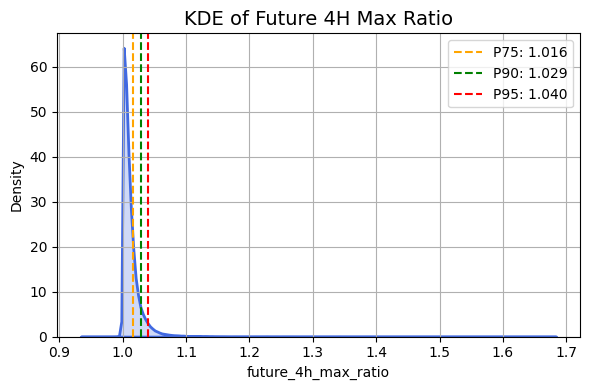

In [4]:
# =============================================================================
# KDE PLOT FOR FUTURE 4H MAX RATIO + PERCENTILE LINES
# =============================================================================
import matplotlib.pyplot as plt
import seaborn           as sns

# Drop NaN values (az utolsó sorokban lehet)
ratios = df['future_4h_max_ratio'].dropna()

# Percentilis küszöbök
p75 = ratios.quantile(0.75)
p90 = ratios.quantile(0.90)
p95 = ratios.quantile(0.95)

# Plot
plt.figure(figsize=(6, 4))
sns.kdeplot(ratios, fill=True, linewidth=2, color="royalblue")

# Percentilis vonalak
plt.axvline(p75, color='orange', linestyle='--', label=f'P75: {p75:.3f}')
plt.axvline(p90, color='green' , linestyle='--', label=f'P90: {p90:.3f}')
plt.axvline(p95, color='red'   , linestyle='--', label=f'P95: {p95:.3f}')

plt.title('KDE of Future 4H Max Ratio', fontsize=14)
plt.xlabel('future_4h_max_ratio')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# =============================================================================
# DEFINE THRESHOLD AND BINARY FLAG COLUMN
# =============================================================================
# Compute 90th percentile as cutoff
cutoff_ratio = df['future_4h_max_ratio'].quantile(0.90)

# Binary flag: 1 if ratio > cutoff, else 0
df['spike_flag'] = (df['future_4h_max_ratio'] > cutoff_ratio).astype(int)

print(f"Cutoff (P90) value: {cutoff_ratio:.4f}")
print("Spike flag counts:\n", df['spike_flag'].value_counts())

# =============================================================================
# PROCESSED DATAFRAME WITHOUT FINAL 4H WINDOW
# =============================================================================
# Drop last 240 rows (no future data to compute ratios)
df_processed = df.iloc[:-240].copy()

# Optional check
print("Original rows:" , len(df))
print("Processed rows:", len(df_processed))

# =============================================================================
# SAVE PROCESSED DATAFRAME TO PARQUET
# =============================================================================
output_path = 'data/bchusdt_1m_processed.parquet'
df_processed.to_parquet(output_path, index=False)
print(f"Processed data saved to: {output_path}")

Cutoff (P90) value: 1.0286
Spike flag counts:
 spike_flag
0    2790258
1     309996
Name: count, dtype: int64
Original rows: 3100254
Processed rows: 3100014
Processed data saved to: data/bchusdt_1m_processed.parquet
